In [1]:
import Pkg; Pkg.add(["Plots"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; plotlyjs(); default(l=5, size=(900,550), label=false);
using Printf;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=:diverging_gwv_55_95_c39_n256
        ; kwargs...
    )
end
p = plot!([0,1],[0,1]);

WebIO._IJuliaInit()

**(Follow along: <https://tinyurl.com/gtcse6643lec14>)**

## Warmup

**T&B Exercise 19.1.** Given $A \in \mathbb{C}^{m \times n}$ of rank $n$ and $b\in \mathbb{C}^m$, consider the block $2 \times 2$ system of equations

$$
\begin{bmatrix} I & A \\ A^* & 0 \end{bmatrix}
\begin{bmatrix} r \\ x \end{bmatrix}
=
\begin{bmatrix} b \\ 0 \end{bmatrix},
$$

where $I$ is the $m \times m$ identity.  Show that this system has a unique solution $(r,x)^T$, and that the vectors $r$ and $x$ are the residual and the solution of the least squares problem.

# Stability of Least Squares Algorithms

**1. Review**

**2. Householder Triangularization**

**3. Gram-Schmidt**

**4. Normal Equations**

## Review

### T&B Theorem 18.1

Let $b \in \mathbb{C}^m$ and $A \in \mathbb{C}^{m \times n}$ of full rank be fixed.  The least squares problem
has the following 2-norm condition numbers describing the sensitivities of $y$ and $x$ to perturbations in $b$ and $A$:

| ${}$ | $y$ | $x$ |
| :-:  | :-: | :-: |
| $b$  | $\frac{1}{\cos\theta}$ | $\frac{\kappa(A)}{\eta \cos\theta}$ |
| $A$  | $\frac{\kappa(A)}{\cos\theta}$ | $\kappa(A) + \frac{\kappa(A)^2 \tan \theta}{\eta}$ |

The results in the first row are exact, being attained for certain perturbations $\delta b$, and the results in the secod row are upper bounds.

In [4]:
cond_y_b(κ, θ, η) = 1 / cos(θ);

In [5]:
cond_x_b(κ, θ, η) = κ / η / cos(θ);

In [6]:
cond_y_A(κ, θ, η) = κ / cos(θ);

In [7]:
cond_x_A(κ, θ, η) = κ + κ^2 * tan(θ) / η;

Let's test these predictions

In [8]:
function generate_ls_problem(m, n, κ, θ, η, n_samples = 0, noise = 0, U = nothing, V = nothing, Q = nothing)
    """
    Create a random least squares problem with the desired conditioning factors
    and generate some noisy versions of the data
    
    # Arguments
    
    - `m`, `n`: the dimensions of the least squares problem
    - `κ`: the 2-norm condition number of `A`
    - `θ`: the angle of `b` to range(A)
    - `η`: the ratio of ||x|| to ||y||
    - `n_samples`: the number of samples to generate
    - `noise`: the amount of noise to add
    
    # Returns
    
    - `x`: the original solution
    - `y`: the original projection
    - `As`: system matrices
    - `bs`: right-hand sides
    
    Compute `y = A*x` and `b = y + r` to construct the right hand side of the least squares problem
    """
    @assert(m >= n)
    @assert(κ >= 1.0)
    @assert(η >= 1.0 && κ >= η)
    
    # generate a random square matrix with the desired
    # condition number
    σ = LinRange(1.0, 1.0 / κ, n)
    if U == nothing
        U = qr(randn(n,n)).Q
    end
    if V == nothing
        V = qr(randn(n,n)).Q
    end
    A = zeros(m, n)
    A[1:n,1:n] = U * diagm(σ) * V'
    
    # create a solution vector with norm η cos θ
    x = zeros(n)
    ϕ = 1 / η
    # spread the support of x out widely over the singular vectors
    # pairing large and small singular values appropriately scaled
    # to guarantee ||x|| = η ||y||
    for i = 1:div(n,2)
        s = σ[i]
        t = σ[end-(i-1)]
        if (s >= ϕ && t <= ϕ)
            if s == t
                x[i] = 1.
                x[end-(i-1)] = 1.
            else
                c = (ϕ+t)*(ϕ-t)/(s+t)/(s-t)
                x[i] = sqrt(c)
                x[end-(i-1)] = sqrt(1 - c)
            end
        end
    end
    x = V * x
    # normalize x so that ||y|| = 1
    xnorm = norm(x)
    x *= η / xnorm
    
    # set up a right hand side where ||b|| = 1 and ||y = Pb|| = cos θ
    c = cos(θ)
    s = sin(θ)
    # rescale x so ||y|| = cos θ
    x *= c
    r = zeros(m)
    # put sin θ in the last component (this will be the residual r)
    r[end] = s
    
    # randomly rotate the columns
    if Q == nothing
        Q = qr(randn(m,n)).Q
    end
    A = Q'*A
    r = Q'*r
    y = A * x
    b = y + r
    
    if n_samples == 0
        return x, y, A, b
    else
        As = Vector{Matrix{Float64}}(undef, n_samples)
        bs = Vector{Vector{Float64}}(undef, n_samples)
        for i = 1:n_samples
            As[i] = A .+ A .* randn(m, n) * noise
            bs[i] = b .+ b .* randn(m) * noise 
        end
        return x, y, As, bs
    end
end

generate_ls_problem (generic function with 6 methods)

In [9]:
gr();
function plot_prediction(κs, θs, ηs, target, n_samples=30)
    n_samples = 30
    if target == :kappa
        ran = exp.(LinRange(log.(κs[1]), log.(κs[end]), 100))
        xb = cond_x_b.(ran, θs[1], ηs[1])
        xA = cond_x_A.(ran, θs[1], ηs[1])
        yb = cond_y_b.(ran, θs[1], ηs[1])
        yA = cond_y_A.(ran, θs[1], ηs[1])
        xlim = (κs[1], κs[end])
        xlabel = "κ"
        legend = :topleft
    elseif target == :theta
        ran = exp.(LinRange(-log(cos(θs[1])), -log(cos(θs[end])), 100))
        xb = cond_x_b.(κs[1], acos.(1 ./ ran), ηs[1])
        xA = cond_x_A.(κs[1], acos.(1 ./ ran), ηs[1])
        yb = cond_y_b.(κs[1], acos.(1 ./ ran), ηs[1])
        yA = cond_y_A.(κs[1], acos.(1 ./ ran), ηs[1])
        xlim = (1/cos(θs[1]), 1/cos(θs[end]))
        xlabel = "cos⁻¹(θ)"
        legend = :topleft
    else
        ran = exp.(LinRange(log.(ηs[1]), log.(ηs[end]), 100))
        xb = cond_x_b.(κs[1], θs[1], ran)
        xA = cond_x_A.(κs[1], θs[1], ran)
        yb = cond_y_b.(κs[1], θs[1], ran)
        yA = cond_y_A.(κs[1], θs[1], ran)
        xlim = (ηs[1], ηs[end])
        xlabel = "η"
        legend = :topright
    end
    anim = Animation()
    m = 3
    n = 2
    noise = eps() * 100
    p = plot(aspect_ratio=:equal)
    q = plot()
    s = plot(ran, noise .* xA
        , xlim=xlim
        , xscale=:log10
        , xlabel=xlabel
        , label="δx/δA"
        , yscale=:log10
        , legend = legend
        , title="||x̂ - x|| / ||x||")
    plot!(s, ran, noise .* xb
        , label="δx/δb"
    )
    t = plot(ran, noise .* yA
        , xlim=xlim
        , xscale=:log10
        , xlabel=xlabel
        , label="δy/δA"
        , yscale=:log10
        , legend = legend
        , title="||ŷ - y|| / ||y||")
    plot!(t, ran, noise .* yb
        , label="δy/δb"
    )
    U = qr(randn(n,n)).Q
    V = qr(randn(n,n)).Q
    Q = qr(randn(m,n)).Q

    for (κ, θ, η) in zip(κs, θs, ηs)
        if target == :kappa
            val = κ
        elseif target == :theta
            val = 1/cos(θ)
        else
            val = η
        end
        y_rel_errs = zeros(n_samples, m)
        x_rel_errs = zeros(n_samples, n)
        x, y, As, bs = generate_ls_problem(m, n, κ, θ, η, n_samples, noise, U, V, Q)
        for i in 1:n_samples
            Q, R = qr(As[i])
            b₁ = (Q' * bs[i])[1:n]
            ŷ = Q[:,1:2] * b₁
            x̂ = R \ b₁
            x_rel_errs[i,:] = (x - x̂) ./ norm(x)
            y_rel_errs[i,:] = (y - ŷ) ./ norm(y)
        end
        plot!(p, x_rel_errs[:,1], x_rel_errs[:,2], st=:scatter, title="(x̂ - x) / ||x||")
        plot!(q, y_rel_errs[:,1], y_rel_errs[:,2], y_rel_errs[:,3], st=:scatter, title="(ŷ - y) / ||y||")
        plot!(s, repeat([val], n_samples), [norm(x_rel_errs[i,:]) for i in 1:n_samples])
        plot!(t, repeat([val], n_samples), [norm(y_rel_errs[i,:]) for i in 1:n_samples])
        frame(anim, plot(q, p, t, s, layout=(2,2), plot_title="κ = $(sciprint(κ)), θ = $(sciprint(θ)), η = $(sciprint(η))"))
    end
    return gif(anim, "lec13-xs.gif", fps=0.5)
end;

## Fix $\theta \neq 0$ and $\eta$ and vary $\kappa$

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/lec13-xs.gif")
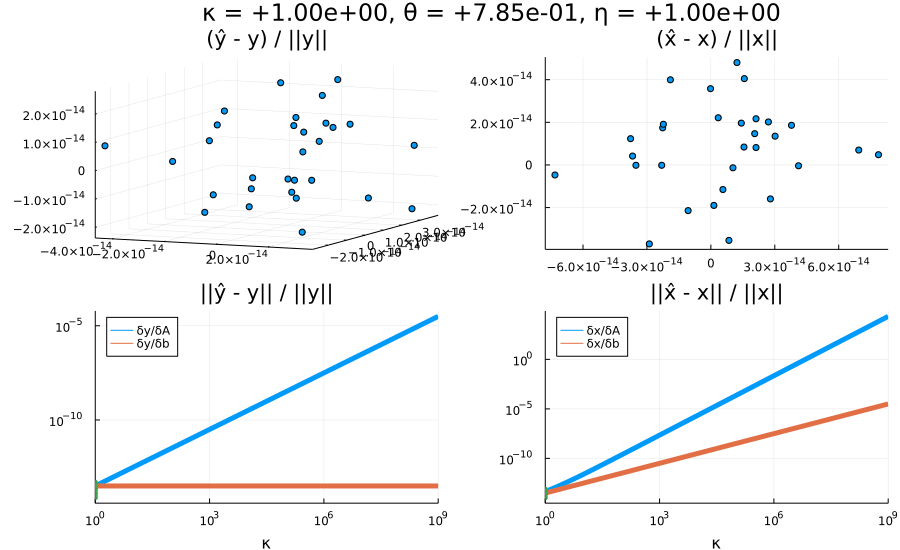

In [10]:
plot_prediction(10 .^ (0:9), repeat([π/4],10), repeat([1],10), :kappa)

## Fix $\theta = 0$ and $\eta$ and vary $\kappa$

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/lec13-xs.gif")
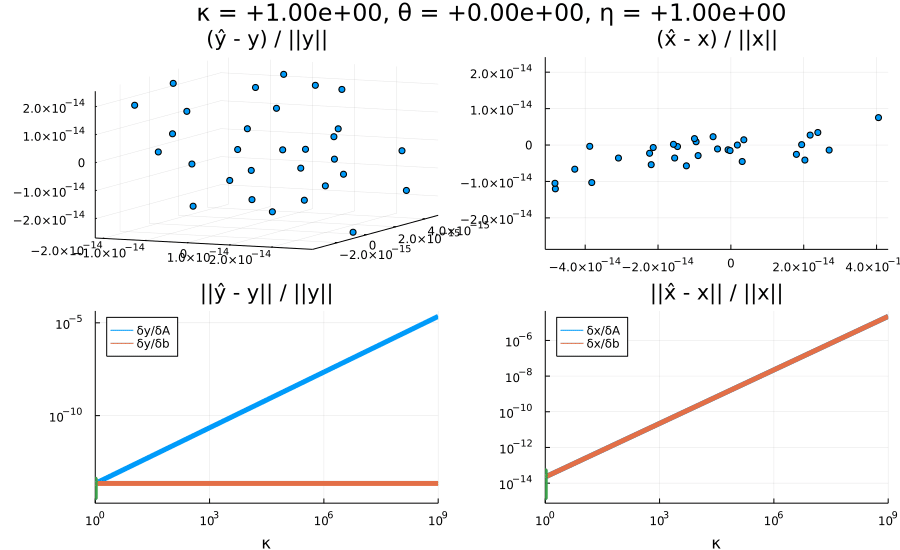

In [11]:
plot_prediction(10 .^ (0:9), repeat([0],10), repeat([1],10), :kappa)

## Fix $\theta = 0$ and vary $\kappa$ and $\eta \propto \kappa$

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/lec13-xs.gif")
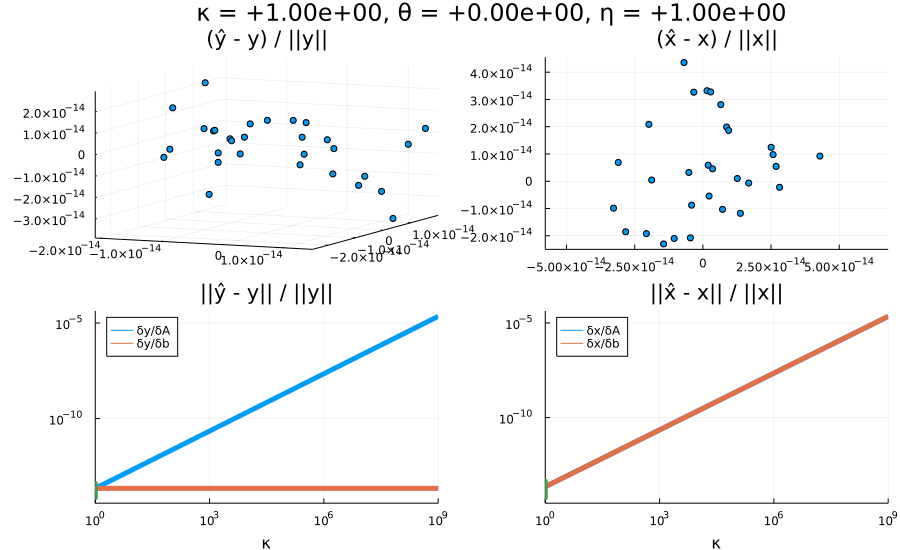

In [12]:
plot_prediction(10 .^ (0:9), repeat([0],10), max.(1,(10 .^ (0:9)) ./ 2), :kappa)

## Fix $\kappa$ and $\eta$ and vary $\theta$

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/lec13-xs.gif")
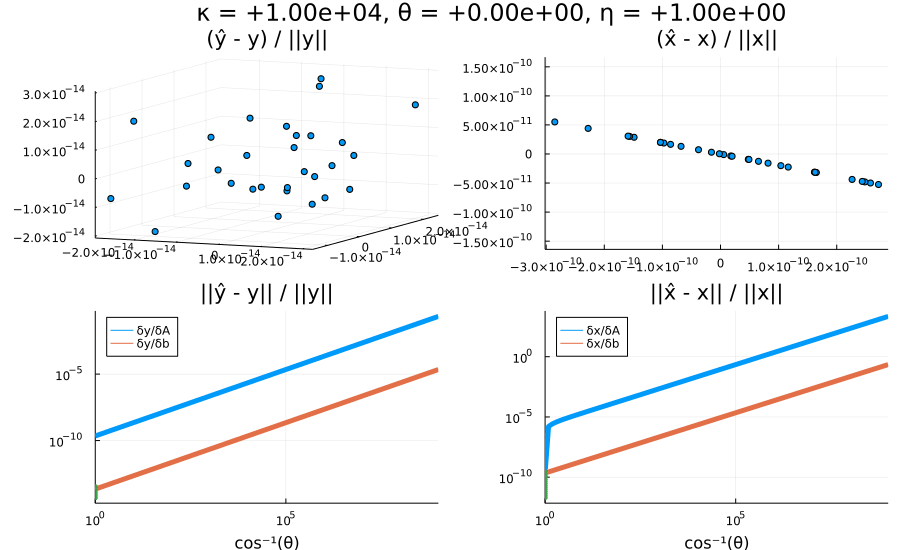

In [13]:
plot_prediction(repeat([1.e4],10), acos.(10.0 .^ (0:-1:-9)), repeat([1],10), :theta)

## Fix $\kappa$ and $\theta \neq 0$ and vary $\eta$

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/lec13-xs.gif")
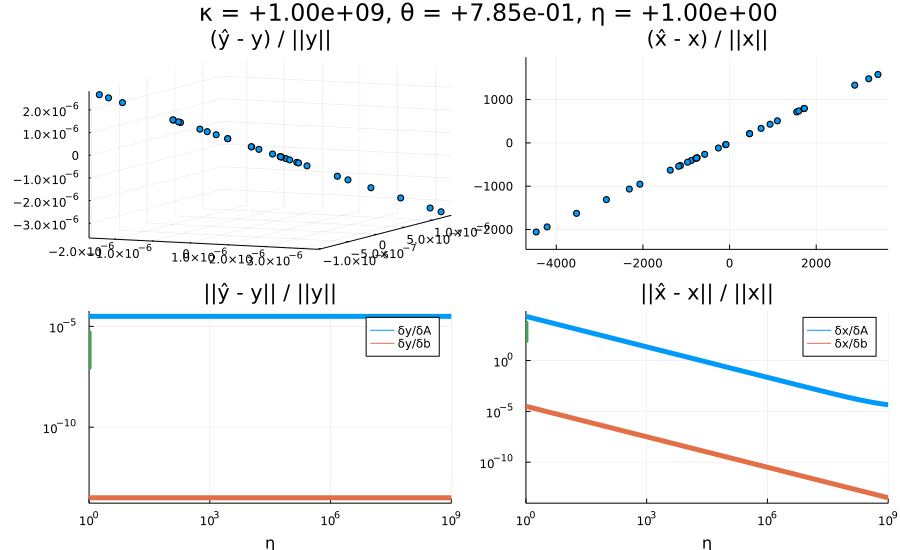

In [14]:
plot_prediction(repeat([1.e9],10), repeat([π/4],10), 10.0 .^ (0:9), :eta)

## Fix $\kappa$ and $\theta = 0$ and vary $\eta$

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/lec13-xs.gif")
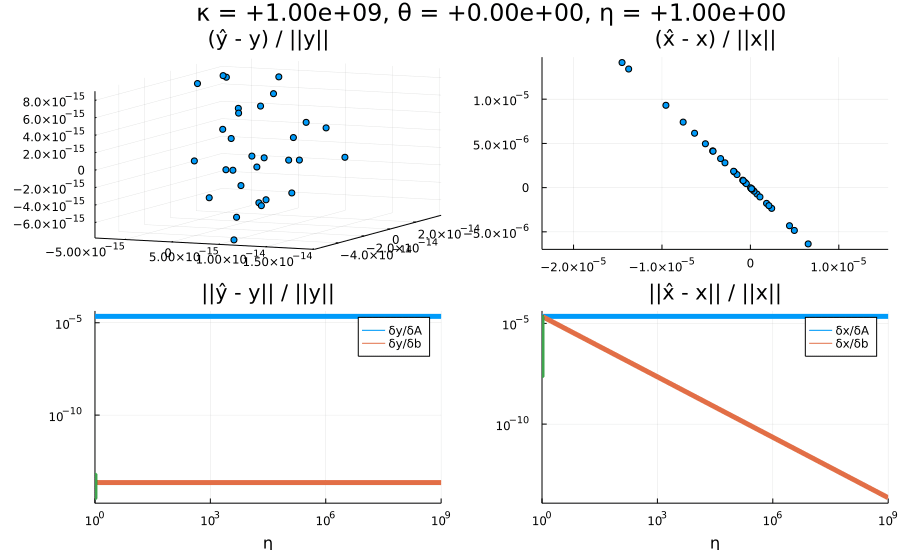

In [15]:
plot_prediction(repeat([1.e9],10), repeat([0],10), 10.0 .^ (0:9), :eta)

In [16]:
function householder_solve(A, b)
    Q, R = qr(A) # Factor A by Householder triangularization
    z = Q' * b   # Compute Q* b by applying the reflectors in order
    x = R \ z    # Solve the triangular system R x = y by back substitution
    return x
end;

### T&B Theorem 16.2.

`householder_solve` is backward stable, satisfying

$$
(A + \Delta A) \tilde x = b, \quad \frac{\|\Delta A\|}{\|A\|} = O(\epsilon_{\text{machine}})
$$

for some $\Delta A \in \mathbb{C}^{m \times m}$.

- Does anything change when this algorithm is used as a least-squares solver?

- If $\tilde{z} = z + \delta z$, then

$$\tilde{z}_{1:n} = (z + \delta z)_{1:n}.$$

### Stability of Householder Least Squares algorithms

### Householder Triangularization

In [17]:
function householder_ls(A, b)
    m, n = size(A)
    Q, R = qr(A)
    z = Q[:,1:n]' * b
    x = R \ z
    return x
end;

In [18]:
m = 100; n = 15;
κ = 2e10; θ = 4e-6; η = 2e5;
x, y, A, b = generate_ls_problem(m, n, κ, θ, η)
x̂ = householder_ls(A, b)
maximum(abs.((x̂ - x) ./ x))

1.4389154901539325e-6

$ $

In [19]:
eps() * cond_x_A(κ, θ, η)

6.217248937910351e-6

In [20]:
eps() * cond_x_b(κ, θ, η)

2.2204460492680768e-11

Note that in `Q[:,1:n]' * b` we are forming $Q$.  If we had done `(Q' * b)[:,1:n]` julia would apply the Householder reflectors.

Does it matter? What can we do in a language like matlab that only returns a formed matrix $Q$?

In [42]:
function householder_ls_augmented(A, b)
    m, n = size(A)
    Q, R = qr([A b])
    z = R[1:n,n+1]
    x = R[1:n,1:n] \ z
    return x
end;

In [45]:
m = 100; n = 15;
κ = 2e10; θ = 4e-6; η = 2e5;
x, y, A, b = generate_ls_problem(m, n, κ, θ, η)
x̂ = householder_ls_augmented(A, b)
maximum(abs.((x̂ - x) ./ x))

3.090032602737993e-7

In [46]:
x̂_orig = householder_ls(A, b)
maximum(abs.((x̂_orig - x) ./ x))

3.8877052543493877e-7

**Conclusion:**

> The errors introduced in QR factorization of $A$ swamp those introduced in the computation of $\hat{Q}^* b$.

### What about backslash?

In [47]:
m = 100; n = 15;
κ = 2e10; θ = 4e-6; η = 2e5;
x, y, A, b = generate_ls_problem(m, n, κ, θ, η)
x̂ = householder_ls_augmented(A, b)
maximum(abs.((x̂ - x) ./ x))

3.4758572366961774e-8

In [48]:
x̂_bs = A \ b
maximum(abs.((x̂_bs - x) ./ x))

2.577140850821662e-8

In [49]:
maximum(abs.((x̂_bs - x̂) ./ x̂))

8.987164171126148e-9

### Column Pivoted QR: a QR factorization of permuted $A$,  $QR = AP$

In [27]:
function householder_ls_pivoted(A, b)
    m, n = size(A)
    QR = qr(A, ColumnNorm())    # Compute a rank-revealing QR factorization with column pivoting
    Q, R, P = QR.Q, QR.R, QR.P  # P is a permutation matrix such that Q R = A P
    z = (Q' * b)[1:n]           # Apply reflectors to b
    x_permuted = R \ z
    x = P * x_permuted
    return x
end;

In [28]:
m = 100; n = 15;
κ = 2e10; θ = 4e-6; η = 2e5;
x, y, A, b = generate_ls_problem(m, n, κ, θ, η)
x̂ = householder_ls_pivoted(A, b)
maximum(abs.((x̂ - x) ./ x))

1.5065076580680063e-8

In [29]:
x̂_bs = A \ b
maximum(abs.((x̂_bs - x) ./ x))

1.5065076580680063e-8

In [30]:
maximum(abs.(x̂_bs - x̂))

0.0

For least squares, we want to be able to solve _a_ triangular system, because it has a direct, $O(n^2)$ backward stable algorithm:

In [31]:
function backsubstitution(R, b)
    m = length(b)
    x = copy(b)
    for j = m:-1:1
        x[j] /= R[j,j]
        x[1:j-1] -= R[1:j-1,j] * x[j]
    end
    return x
end;

But if we don't care about preserving the order of the original columns, is there an order that makes `backsubstitution` more accurate?

**Observation:** In line 6, errors present in $x_j$ get magnified by $|1 / r_{jj}|$: it is better for $|r_{jj}|$ to be larger.

### Exercise

The first two Householder reflectors have been applied to $A$, so the first two rows are complete.
**If we are allowed to permute (pivot) columns 3, 4, & 5** before we compute the next Householder reflector,
what are the possible values of $|r_{33}|$?

$$
\begin{bmatrix}
r_{11} & r_{12} & r_{13} & r_{14} & r_{15} \\
       & r_{22} & r_{23} & r_{24} & r_{25} \\ \hline
       &        & \hat{a}_{33} & \hat{a}_{34} & \hat{a}_{35} \\
       &        & \hat{a}_{43} & \hat{a}_{44} & \hat{a}_{45} \\
       &        & \hat{a}_{53} & \hat{a}_{54} & \hat{a}_{55}
\end{bmatrix}
$$

### Rank revealing QR factorization (RRQR)

Pivoting based on the trailing column norms works well in practice as a **rank revealing QR factorization**: if $A$ has rank $r$, we want

$$
Q^* A P = \begin{bmatrix}
R_{11} & R_{12} \\ 0 & 0
\end{bmatrix}
$$

In contrast to a general QR factorization, the rank of $A$ is equal to the number of nonzeros on the diagonal of $R$ in a RRQR factorization (in exact arithmetic).

Numerically, a RRQR algorithm still be defeated by corner-case matrices (the Kahan matrix again).

RRQR algorithms are more expensive and less parallelizable than QR algorithms

### T&B Theorem 19.1

Let the full-rank least squares problem be solved by Householder triangularization on a computer satisfying the floating point axioms.  This algorithm is backward stable:

$$
\tilde{x} = \arg\min_x ||(A + \delta A)x - b||, \quad \frac{\|\delta A\|}{\|A\|} = O(\epsilon_{\text{machine}})$$

for some $\delta A \in \mathbb{C}^{m \times n}$.  This is true whether $\hat{Q}^*b$ is computed via explicit formation of $\hat{Q}$ or implicitly by Algorithm 10.2.  It also holds for Householder triangularization with arbitrary column pivoting.

## Gram-Schmidt Orthogonalization

In [32]:
function mgs(A)
    n = size(A)[2]
    Q = copy(A)
    R = zeros(eltype(A), n, n)
    for i in 1:n
        R[i,i] = norm(Q[:,i])
        Q[:,i] /= R[i,i] 
        R[i,i+1:n] = Q[:,i]' * Q[:,i+1:n]
        Q[:,i+1:n] -= Q[:,[i]] * R[[i],i+1:n]
    end
    return Q,  R
end

mgs (generic function with 1 method)

### Modified Gram-Schmidt applied directly is not stable

In [33]:
function mgs_ls(A, b)
    Q, R = mgs(A)
    z = Q' * b
    x = R \ z
    return x
end

mgs_ls (generic function with 1 method)

In [34]:
m = 100; n = 15;
κ = 2e10; θ = 4e-6; η = 2e5;
x, y, A, b = generate_ls_problem(m, n, κ, θ, η)
x̂ = mgs_ls(A, b)
maximum(abs.((x̂ - x) ./ x))

0.020041341316257878

For a general factorization $A = MR$, $M$ not unitary, we can solve the least squares problem by

$$
\begin{aligned}
z &\gets M^+ b &[= (M^* M)^{-1} M^* b]\\
x &\gets R^{-1} z.
\end{aligned}
$$

But with the **loss of orthogonality** in the computed $\tilde{Q}$ from Gram-Schmidt orthogonalization,

$$\tilde{Q}^* \neq \tilde{Q}^+,$$

even though this is true for unitary matrices.

### Modified Gram-Schmidt on the augmented matrix $[A | b]$

In [35]:
function mgs_ls_augmented(A, b)
    n = size(A)[2]
    Q, R = mgs([A b])
    z = R[1:n,n+1]
    x = R[1:n,1:n] \ z
    return x
end

mgs_ls_augmented (generic function with 1 method)

In [36]:
m = 100; n = 15;
κ = 2e10; θ = 4e-6; η = 2e5;
x, y, A, b = generate_ls_problem(m, n, κ, θ, η)
x̂ = mgs_ls_augmented(A, b)
maximum(abs.((x̂ - x) ./ x))

2.576310857837665e-7

### Why?

Björck & Paige, _Loss and Recapture of Orthogonality in the Modified Gram-Schmidt Algorithm_, 1992.

(Sketch of argument) Modified Gram-Schmidt is operation-for-operation equivalent to Householder triangularization applied to

$$
\begin{bmatrix}
0_n \\
A | b
\end{bmatrix} = \tilde{P} \tilde{R}, \tilde{P} = \begin{bmatrix} C & D \\ E & F \end{bmatrix}
$$

so applying MGS to $[A|b]$ will have a last column of $R$ that is numerically equivalent to one that has had
multiple Householder reflectors applied to it.



## Normal Equations

In [37]:
function normal_equations_ls(A, b)
    return (A' * A) \ (A' * b)
end

normal_equations_ls (generic function with 1 method)

In [38]:
m = 100; n = 15;
κ = 2e10; θ = 4e-6; η = 2e5;
x, y, A, b = generate_ls_problem(m, n, κ, θ, η)
x̂ = normal_equations_ls(A, b)
maximum(abs.((x̂ - x) ./ x))

1.0004009669672935

### The normal equations contains $A^* A$:

$$(A^* A) x = A^* b.$$

Even assuming $A^* b$ is computed exactly, the condition number of $A^*A$ is unavoidable:

$$
\kappa(A^* A) = \frac{\sigma_1^2}{\sigma_n^2} = \kappa(A)^2.
$$

### Compare that to the conditioning of $x$ with respect to $A$ in theorem 18.1

$$
\kappa(A) + \underbrace{\frac{\kappa(A)^2}{\eta} \tan \theta}_{\star}.
$$

Are there situations where $\star$ is $O(\kappa(A))$?

$$\frac{\tan\theta}{\eta} = O(\kappa(A)^{-1})$$

If $\tan \theta \leq \kappa(A)^{-1}$ (close fit) or $\tan \theta$ is bounded and $\eta \propto \kappa$, then
the conditioning of $x$ with respect to $A$ if $O(\kappa(A))$.

### Stable vs. unstable comparison of $\|\hat{x} - x\|  /\|x\|$

| $\kappa_{A \mapsto x}$ | stable (Householder, augmented MGS) | unstable (normal equations) |
| :-: | :-: | :-: |
| $O(\kappa(A))$ | $O(\kappa(A) \epsilon_{\text{machine}})$ | $O(\kappa(A)^2 \epsilon_{\text{machine}})$ |
| $O(\kappa(A)^2)$ | $O(\kappa(A)^2 \epsilon_{\text{machine}})$ | $O(\kappa(A)^2 \epsilon_{\text{machine}})$ |

A stable algorithm is uniformly stable for all inputs.  Because of the inputs in the top row (such as when the $\theta \approx 0$ (close fits)), the normal equations is not considered stable.

**T&B Theorem 19.3.** The solution of the full-rank least squares problem via the normal equations is unstable. Stability can be achieved, however, by restriction to a class of problems in which $\kappa(A)$ is uniformly bounded above or $(\tan\theta) / \eta$ is uniformly bounded below.

## SVD for least squares

In [39]:
function svd_ls(A, b)
    m, n = size(A)
    U, σ, V = svd(A)
    z = U' * b
    x = V * (z ./ σ)
    return x
end

svd_ls (generic function with 1 method)

In [40]:
m = 100; n = 15;
κ = 2e10; θ = 4e-6; η = 2e5;
x, y, A, b = generate_ls_problem(m, n, κ, θ, η)
x̂ = svd_ls(A, b)
maximum(abs.((x̂ - x) ./ x))

1.0558898071869875e-7

In [41]:
x̂_bs = A \ b
maximum(abs.((x̂_bs - x) ./ x))

1.3426960682608092e-8

**T&B Theorem 19.4.**  The solution of the full-rank least squares problem by the SVD is backward stable.